In [1]:
# import numpy as np
# np.save(f"/media/dan/Data/git/network_miner/julia_v_python_connectivity/org_python_dbg_outputs/e~epoch0_tap0.npy", e)
# np.save(f"/media/dan/Data/git/network_miner/julia_v_python_connectivity/org_python_dbg_outputs/d~epoch0_tap0.npy", d)
# np.save(f"/media/dan/Data/git/network_miner/julia_v_python_connectivity/org_python_dbg_outputs/w~epoch0_tap0.npy", w)
# np.save(f"/media/dan/Data/git/network_miner/julia_v_python_connectivity/org_python_dbg_outputs/windows~epoch0_tap0.npy", windows)
# np.save(f"/media/dan/Data/git/network_miner/julia_v_python_connectivity/org_python_dbg_outputs/w1~epoch0_tap0.npy", w)
# np.save(f"/media/dan/Data/git/network_miner/julia_v_python_connectivity/org_python_dbg_outputs/windows1~epoch0_tap0.npy", windows)
# np.save(f"/media/dan/Data/git/network_miner/julia_v_python_connectivity/org_python_dbg_outputs/fix_even~epoch0_tap0.npy", fix_even)
# np.save(f"/media/dan/Data/git/network_miner/julia_v_python_connectivity/org_python_dbg_outputs/windowsfixeven~epoch0_tap0.npy", windows)
# np.save(f"/media/dan/Data/git/network_miner/julia_v_python_connectivity/org_python_dbg_outputs/windowsthresh~epoch0_tap0.npy", windows)


# import numpy as np
# np.save(f"/media/dan/Data/git/network_miner/julia_v_python_connectivity/org_python_dbg_outputs/eigvals~epoch0_tap0.npy", a)
# np.save(f"/media/dan/Data/git/network_miner/julia_v_python_connectivity/org_python_dbg_outputs/eigvecs~epoch0_tap0.npy", b)


# import pickle
# with open(f"/media/dan/Data/git/network_miner/julia_v_python_connectivity/org_python_dbg_outputs/Ws~epoch0.pkl", "wb") as f:
#     pickle.dump(out, f)


In [2]:
using NPZ
using LinearAlgebra
using FFTW
using PyCall

In [3]:
output_path = "/media/dan/Data/git/network_miner/julia_v_python_connectivity/python_outputs"
output_org_path = "/media/dan/Data/git/network_miner/julia_v_python_connectivity/org_python_dbg_outputs/"

"/media/dan/Data/git/network_miner/julia_v_python_connectivity/org_python_dbg_outputs/"

In [4]:
py"""
import pickle
 
def load_pickle(fpath):
    with open(fpath, "rb") as f:
        data = pickle.load(f)
    return data
"""

load_pickle = py"load_pickle"


PyObject <function load_pickle at 0x708415557b00>

Check Ws vs orig

In [5]:
# index like this: Ws[1,1] == python Ws[0][0]
Ws_org = load_pickle("/media/dan/Data/git/network_miner/julia_v_python_connectivity/org_python_dbg_outputs/Ws~epoch0.pkl")

Ws = load_pickle("/media/dan/Data/git/network_miner/julia_v_python_connectivity/python_outputs/Ws~epoch0.pkl")
@assert Ws == Ws_org

Input to _cwt_gen same?

In [6]:
X_org = npzread(joinpath(output_org_path, "x~epoch0_channel0.npy"))
X = npzread(joinpath(output_path, "X_tfl~epoch0_channel0.npy"))
@assert X == X_org

FFT same?

In [7]:
fft_Ws_org = npzread(joinpath(output_org_path, "fft_Ws~epoch0_channel0_taper0.npy"))
fft_Ws = npzread(joinpath(output_path, "fft_Ws~epoch0_channel0_taper0.npy"))
@assert fft_Ws == fft_Ws_org

first taper?

In [8]:
tap_org = npzread(joinpath(output_org_path, "ret_centered~epoch0_channel0_taper0_xidx0_wavelet0.npy"))
tap = npzread(joinpath(output_path, "ret_centered~epoch0_channel0_taper0_xidx0_wavelet0.npy"))
@assert tap == tap_org

In [9]:
for i = 1:13
    tap_org = npzread(joinpath(output_org_path, "ret_centered~epoch0_channel0_taper0_xidx0_wavelet$(i).npy"))
    tap = npzread(joinpath(output_path, "ret_centered~epoch0_channel0_taper0_xidx0_wavelet$(i).npy"))
    @assert tap == tap_org
end

tfrs same?

In [10]:
tfrs_org = npzread(joinpath(output_org_path, "tfrs~epoch0_channel0.npy"))
tfrs = npzread(joinpath(output_path, "tfrs~epoch0_channel0.npy"))
@assert tfrs == tfrs_org

First check if output from modified python matches original

In [11]:
# load array shaped (epoch,channel,channel,band) (1 in this case) for average
original_output = "coh_favg_unmodified_python.npy"
original_output = npzread(joinpath(output_org_path, original_output));

epochs = size(original_output, 1) -1
n = size(original_output, 2) -1
for epoch_idx in 0:epochs
    for t in 0:n
        for s in (t+1):n
            org = original_output[1, s+1, t+1, 1]
            new = npzread(joinpath(output_path,"conn_favg~epoch$(epoch_idx)_source$(s)_target$(t).npy"))[1]
            @assert org == new

        end
    end
end


# Original is the same as the python output code
## time to check julia outputs

In [12]:
using DSP: dpss
using FFTW
using Statistics
using LinearAlgebra
using Plots
using Printf
using FilePathsBase

In [95]:
function sinusoidal(a, f, sr, t, theta=0, DC=0)
    delta_i = 1 / sr
    f2pi = f * 2 * π
    nu = [DC + (a * sin(f2pi * i * delta_i + theta)) for i in 0:(t-1)]
    return nu
end

# Optimized zero pad function
function zero_pad!(data_padded, data)
    data_padded[1:length(data)] .= data
    data_padded[length(data)+1:end] .= 0
end

function coh(s_xx, s_yy, s_xy)
    # Compute the numerator: absolute value of the mean of s_xy along the last dimension
    con_num = abs.(mean(s_xy, dims=ndims(s_xy)))

    # Compute the denominator: square root of the product of means of s_xx and s_yy along the last dimension
    con_den = sqrt.(mean(s_xx, dims=ndims(s_xx)) .* mean(s_yy, dims=ndims(s_yy)))

    # Calculate coherence as the element-wise division of numerator by denominator
    coh = con_num ./ con_den
    return coh
end


function next_fast_len(target::Int)::Int
    """
    Find the next fast size of input data to `fft`, for zero-padding, etc.

    Returns the next composite of the prime factors 2, 3, and 5 which is
    greater than or equal to `target`. (These are also known as 5-smooth
    numbers, regular numbers, or Hamming numbers.)

    Parameters
    ----------
    target : Int
        Length to start searching from. Must be a positive integer.

    Returns
    -------
    out : Int
        The first 5-smooth number greater than or equal to `target`.
    """
    # Precomputed Hamming numbers (5-smooth numbers) for quick lookup
    hams = [
        8, 9, 10, 12, 15, 16, 18, 20, 24, 25, 27, 30, 32, 36, 40, 45, 48, 50,
        54, 60, 64, 72, 75, 80, 81, 90, 96, 100, 108, 120, 125, 128, 135, 144,
        150, 160, 162, 180, 192, 200, 216, 225, 240, 243, 250, 256, 270, 288,
        300, 320, 324, 360, 375, 384, 400, 405, 432, 450, 480, 486, 500, 512,
        540, 576, 600, 625, 640, 648, 675, 720, 729, 750, 768, 800, 810, 864,
        900, 960, 972, 1000, 1024, 1080, 1125, 1152, 1200, 1215, 1250, 1280,
        1296, 1350, 1440, 1458, 1500, 1536, 1600, 1620, 1728, 1800, 1875, 1920,
        1944, 2000, 2025, 2048, 2160, 2187, 2250, 2304, 2400, 2430, 2500, 2560,
        2592, 2700, 2880, 2916, 3000, 3072, 3125, 3200, 3240, 3375, 3456, 3600,
        3645, 3750, 3840, 3888, 4000, 4050, 4096, 4320, 4374, 4500, 4608, 4800,
        4860, 5000, 5120, 5184, 5400, 5625, 5760, 5832, 6000, 6075, 6144, 6250,
        6400, 6480, 6561, 6750, 6912, 7200, 7290, 7500, 7680, 7776, 8000, 8100,
        8192, 8640, 8748, 9000, 9216, 9375, 9600, 9720, 10000
    ]

    if target <= 6
        return target
    end

    # Check if target is already a power of 2
    if (target & (target - 1)) == 0
        return target
    end

    # Quick lookup for small sizes
    if target <= hams[end]
        idx = searchsortedfirst(hams, target)
        return hams[idx]
    end

    # Function to compute the bit length of an integer
    bit_length(x::Int) = x <= 0 ? 0 : floor(Int, log2(x)) + 1

    match = typemax(Int)  # Initialize with maximum possible integer
    p5 = 1
    while p5 < target
        p35 = p5
        while p35 < target
            # Ceiling integer division
            quotient = cld(target, p35)
            p2 = 2^bit_length(quotient - 1)
            N = p2 * p35
            if N == target
                return N
            elseif N < match
                match = N
            end
            p35 *= 3
            if p35 == target
                return p35
            end
        end
        if p35 < match
            match = p35
        end
        p5 *= 5
        if p5 == target
            return p5
        end
    end
    if p5 < match
        match = p5
    end
    return match
end

function _get_nfft(Ws, X)::Int
    max_len = maximum([length(Wk) for Wk in Ws])
    n = last(size(X))
    nfft = n + max_len - 1
    # @show nfft
    nfft = next_fast_len(nfft)
    return nfft
end

# Precompute FFTs of Ws
function precompute_fft_Ws(Ws, nfft)
    n_taps, n_freqs = size(Ws)
    fft_Ws = Array{ComplexF64,3}(undef, n_taps, n_freqs, nfft)
    for taper_idx = 1:n_taps
        for freq_idx = 1:n_freqs
            W = Ws[taper_idx, freq_idx]
            padded_W = zeros(ComplexF64, nfft)
            zero_pad!(padded_W, W)
            fft_Ws[taper_idx, freq_idx, :] = fft(padded_W)
        end
    end
    return fft_Ws
end

# Precompute FFTs of X
function precompute_fft_X(X, nfft)
    n_epochs, n_channels, n_times = size(X)
    fft_X = Array{ComplexF64,3}(undef, n_epochs, n_channels, nfft)
    for epoch_idx = 1:n_epochs
        for channel_idx = 1:n_channels
            x = X[epoch_idx, channel_idx, :]
            padded_x = zeros(ComplexF64, nfft)
            zero_pad!(padded_x, x)
            fft_X[epoch_idx, channel_idx, :] = fft(padded_x)
        end
    end
    return fft_X
end


# Main function to compute tfr
function compute_tfr(X, Ws, nfft)
    n_epochs, n_channels, n_times = size(X)
    n_taps, n_freqs = size(Ws)
    tfr = zeros(ComplexF64, n_epochs, n_channels, n_taps, n_freqs, n_times)

    # Precompute FFTs
    fft_Ws = precompute_fft_Ws(Ws, nfft)
    fft_X = precompute_fft_X(X, nfft)

    # Loop over tapers and frequencies
    for taper_idx = 1:n_taps
        for freq_idx = 1:n_freqs
            fft_W = fft_Ws[taper_idx, freq_idx, :]
            W_size = length(Ws[taper_idx, freq_idx])
            total_size = n_times + W_size - 1
            ret_size = total_size
            # Preallocate ret array
            ret = zeros(ComplexF64, ret_size)

            for epoch_idx = 1:n_epochs
                for channel_idx = 1:n_channels
                    fx = fft_X[epoch_idx, channel_idx, :]
                    product = fx .* fft_W
                    ret .= ifft(product)[1:ret_size]

                    # Center the result
                    start = Int(floor((ret_size - n_times) / 2)) + 1
                    end_time = start + n_times - 1
                    tfr[epoch_idx, channel_idx, taper_idx, freq_idx, :] = ret[start:end_time]
                end
            end
        end
    end
    return tfr, fft_Ws, fft_X
end

compute_tfr (generic function with 1 method)

In [14]:
t = 32
sr = 32
f = 2

v = sinusoidal(10, f, sr, t * 4, 0)
w = sinusoidal(10, f, sr, t * 4, π / 4)
y = sinusoidal(10, f, sr, t * 4, π / 2)
z = sinusoidal(10, f, sr, t * 4, π)

data = Array{Float64}(undef, 2, 4, 128)

data[1, :, :] = hcat(v, w, y, z)'
data[2, :, :] = hcat(-v, -w, -y, -z)';
size(data)

(2, 4, 128)

# check if data is same as python output

In [16]:
py_data = npzread(joinpath(output_path, "data.npy"))
@assert data == py_data

LoadError: AssertionError: data == py_data

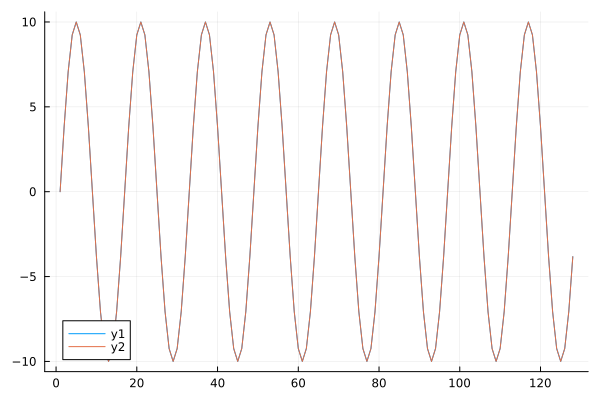

In [17]:
plot(py_data[1, 1, :])
plot!(data[1, 1, :])

In [18]:
for x in 1:size(py_data,3)
    @assert py_data[1, 1, x] == data[1, 1, x] "x: $x, py_data: $(py_data[1, 1, x]), data: $(data[1, 1, x])"
end

LoadError: AssertionError: x: 55, py_data: 7.071067811865487, data: 7.071067811865488

## same to 14 decimal places (rounding errors at end?)

In [19]:
@assert isapprox(py_data,data, atol=1e-14)

### data is essentially the same start processing

In [20]:
freqs = collect(2:15)  # inclusive of end
n_freqs = length(freqs)
mt_bandwidth = 4
n_taps = floor(Int, mt_bandwidth - 1)
n_cycles = 7
sfreq = 32
zero_mean = true
X = data;

#### check t_centered

In [21]:
for epoch_idx = 0:size(data,1)-1
    for taper_idx = 0:n_taps-1
        for k = 1:n_freqs
            f = freqs[k]
            t_win = n_cycles / f
            len_t = Int(ceil(t_win * sfreq))

            # Centered time vector without allocating t and t_centered separately
            t = collect(0:1/sfreq:t_win-(t_win % (1 / sfreq) == 0 ? 1 / sfreq : 0))
            t_centered = t .- t_win / 2.0
            py_t_centered = npzread(joinpath(output_path,"t_centered~epoch$(epoch_idx)_tap$(taper_idx)_freq$(f).npy"))
            @assert t_centered == py_t_centered "epoch_idx: $epoch_idx, taper_idx: $taper_idx, f: $k"
        end
    end
end

t = np.arange(0.0, t_win, 1.0 / sfreq)

t should be from 0 to 3.5 (t_win) exclusive (actual end is 3.46875) with a step of 0.03125

t_centered = (t - t_win / 2.0)

t_centered.min() == np.float64(-1.75)

t_centered.max() == np.float64(1.71875)

diff is 0.03125

### check oscillations

#### not exactly same

In [22]:
for epoch_idx = 0:size(data, 1)-1
    for taper_idx = 0:n_taps-1
        for k = 1:n_freqs
            f = freqs[k]
            t_win = n_cycles / f
            len_t = Int(ceil(t_win * sfreq))

            # Centered time vector without allocating t and t_centered separately
            t = collect(0:1/sfreq:t_win-(t_win % (1 / sfreq) == 0 ? 1 / sfreq : 0))
            t_centered = t .- t_win / 2.0
            oscillation = exp.(2.0 * im * pi * f .* t_centered)

            py_oscillation = npzread(joinpath(output_path, "oscillation~epoch$(epoch_idx)_tap$(taper_idx)_freq$(f).npy"))
            @assert oscillation == py_oscillation "epoch_idx: $epoch_idx, taper_idx: $taper_idx, f: $k"
        end
    end
end

LoadError: AssertionError: epoch_idx: 0, taper_idx: 0, f: 1

same to 14 decimal places 

In [23]:
for epoch_idx = 0:size(data, 1)-1
    for taper_idx = 0:n_taps-1
        for k = 1:n_freqs
            f = freqs[k]
            t_win = n_cycles / f
            len_t = Int(ceil(t_win * sfreq))

            # Centered time vector without allocating t and t_centered separately
            t = collect(0:1/sfreq:t_win-(t_win % (1 / sfreq) == 0 ? 1 / sfreq : 0))
            t_centered = t .- t_win / 2.0
            oscillation = exp.(2.0 * im * pi * f .* t_centered)

            py_oscillation = npzread(joinpath(output_path, "oscillation~epoch$(epoch_idx)_tap$(taper_idx)_freq$(f).npy"))
            @assert isapprox(py_data, data, atol=1e-14) "epoch_idx: $epoch_idx, taper_idx: $taper_idx, f: $k"
        end
    end
end

## check dpss tapers

In [24]:
for epoch_idx = 0:size(data, 1)-1
    for taper_idx = 0:n_taps-1
        for k = 1:n_freqs
            f = freqs[k]
            t_win = n_cycles / f
            len_t = Int(ceil(t_win * sfreq))
            taper = dpss(len_t, mt_bandwidth / 2, n_taps)

            py_taper = npzread(joinpath(output_path, "dpss~epoch$(epoch_idx)_tap$(taper_idx)_freq$(f).npy"))
            @show size(taper), size(py_taper')
            @assert isapprox(taper, py_taper', atol=1e-10) "epoch_idx: $epoch_idx, taper_idx: $taper_idx, f: $k"
        end
    end
end

(size(taper), size(py_taper')) = ((112, 3), (112, 3))


LoadError: AssertionError: epoch_idx: 0, taper_idx: 0, f: 1

## Tapers are not the same. What is different?

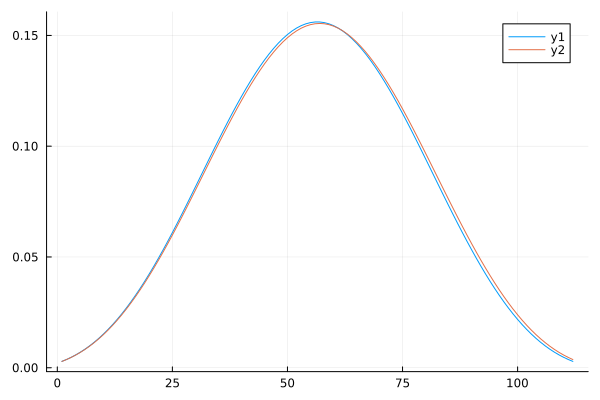

In [ ]:
epoch_idx = 0
taper_idx = 0
k = 1

f = freqs[k]
t_win = n_cycles / f
len_t = Int(ceil(t_win * sfreq))
taper = dpss(len_t, mt_bandwidth / 2, n_taps)
# taper = dpss(len_t, mt_bandwidth / 2, n_taps; padding=10, zerophase=false)

py_taper = npzread(joinpath(output_path, "dpss~epoch$(epoch_idx)_tap$(taper_idx)_freq$(f).npy"))
plot(taper[:, 1])
plot!(py_taper[1, :])

# Taper doesn't even look that close. I guess I have to reimplment the python version

In [25]:
function _extend(M::Int, sym::Bool)
    # Extend window by 1 sample if needed for DFT-even symmetry
    if !sym
        return M + 1, true
    else
        return M, false
    end
end


function _fftautocorr(x::AbstractMatrix{<:Float64})
    """
    tested vs python:
    isapprox(x_fft, py_x_fft, atol=1e-12) == true
    isapprox(py_cxy, cxy, atol=1e-12) == true
    """
    N = size(x, 2)
    use_N = next_fast_len(2 * N - 1)
    x_fft = Array{ComplexF64}(undef, size(x, 1), div(use_N, 2) + 1) # rfft returns N/2 + 1 complex numbers
    padded = zeros(Float64, size(x,1), use_N)
    padded[:, 1:N] .= x
    
    for i = 1:size(x,1)
        x_fft[i, :] = rfft(@view padded[i, :])
    end
    cxy = irfft(x_fft .* conj.(x_fft),use_N,2)[:, 1:N]    
    return cxy
end


_fftautocorr (generic function with 1 method)

# import data exported from build sp_dpss function in python

In [26]:
# load python outputs
py_e = npzread(joinpath(output_org_path, "e~epoch0_tap0.npy"))
py_d = npzread(joinpath(output_org_path, "d~epoch0_tap0.npy"))
py_w = npzread(joinpath(output_org_path, "w~epoch0_tap0.npy"))
py_windows = npzread(joinpath(output_org_path, "windows~epoch0_tap0.npy"))
py_w1 = npzread(joinpath(output_org_path, "w1~epoch0_tap0.npy"))
py_windows1 = npzread(joinpath(output_org_path, "windows1~epoch0_tap0.npy"))
py_fixeven = npzread(joinpath(output_org_path, "fix_even~epoch0_tap0.npy"))
py_windowsfixeven = npzread(joinpath(output_org_path, "windowsfixeven~epoch0_tap0.npy"))
py_windowsthresh = npzread(joinpath(output_org_path, "windowsthresh~epoch0_tap0.npy"))
py_eigvals = npzread(joinpath(output_org_path, "eigvals~epoch0_tap0.npy"))
py_eigvecs = npzread(joinpath(output_org_path, "eigvecs~epoch0_tap0.npy"))

py_x_fft = npzread(joinpath(output_org_path, "x_fft~epoch0_tap0.npy"))
py_cxy = npzread(joinpath(output_org_path, "cxy~epoch0_tap0.npy"))
py_ratios = npzread(joinpath(output_org_path, "ratios~epoch0_tap0.npy"))

py_dpss_rxx = npzread(joinpath(output_org_path, "dpss_rxx~epoch0_tap0.npy"))
py_ratios = npzread(joinpath(output_org_path, "ratios~epoch0_tap0.npy"))

py_windows_approx = npzread(joinpath(output_org_path, "windows_approx_m112~epoch0_tap0.npy"))
py_windows_subsample = npzread(joinpath(output_org_path, "windows_subsample_m112~epoch0_tap0.npy"))


# julia code


M = 112
NW = 2.0
Kmax = 3
sym = false
return_ratios = true
normalize = 2
singleton = false;

Kmax = Int(Kmax)

if !(0 < Kmax <= M)
    error("Kmax must be greater than 0 and less than M")
end
if NW >= M / 2.0
    error("NW must be less than M/2.")
end
if NW <= 0
    error("NW must be positive")
end
M, needs_trunc = _extend(M, sym)
W = NW / M
nidx = collect(0:M-1)
d = ((M - 1 .- 2 .* nidx) ./ 2.0) .^ 2 .* cos.(2pi * W)
e = nidx[2:end] .* (M .- nidx[2:end]) ./ 2.0
@assert d == py_d

@assert e == py_e
T = Tridiagonal(e, d, e)
eigs = eigen(T)
eigvals1 = eigs.values
@assert eigvals1 == py_eigvals
eigvecs1 = eigs.vectors
@assert eigvecs1 == py_eigvecs

indices = M-Kmax+1:M
eigvals = eigvals1[indices]
@assert isapprox(eigvals, py_w, atol=1e-12) # weirdly the values are the same in the full save but slighly different saving only a part
eigvals = reverse(eigvals)
@assert isapprox(eigvals, py_w1, atol=1e-12) # python line 2057; reverses the array for some reason


eigvecs = eigvecs1[end:-1:1, indices]; # not 100% sure why it but it is reversed vs python even though full array is the same
@assert isapprox(eigvecs, py_windows, atol=1e-13)
windows = eigvecs[:, end:-1:1]' # they flip and transpose for some reason
@assert isapprox(windows, py_windows1, atol=1e-13)


# Correct the sign conventions
fix_even = sum(windows[1:2:end, :], dims=2) .< 0
@assert vec(fix_even) == py_fixeven # types are different but values are the same
for (i, f) in enumerate(fix_even)
    if f[1]
        windows[2i-1, :] *= -1
    end
end
@assert isapprox(windows, py_windowsfixeven, atol=1e-13)

thresh = max(1e-7, 1.0 / M)
for (i, w) in enumerate(eachrow(windows[2:2:end, :]))
    idx = findfirst(x -> x^2 > thresh, w)
    if idx !== nothing && w[idx] < 0
        windows[2i, :] *= -1
    end
end
@assert isapprox(windows, py_windowsthresh, atol=1e-13)

# @show size(windows)
if return_ratios
    dpss_rxx = _fftautocorr(windows)
    @assert isapprox(dpss_rxx, py_dpss_rxx, atol=1e-12)
    r = 4 * W * sinc.(2 * W .* nidx)
    r[1] = 2 * W
    ratios = dpss_rxx * r
    @assert isapprox(ratios, py_ratios, atol=1e-12)
    if singleton
        ratios = ratios[1]
    end
end
@assert isapprox(ratios, py_ratios, atol=1e-12)

if normalize != 2 
    # checked vs python and it is the same
    windows .= windows ./ maximum(abs.(windows))
    if iseven(M)
        if normalize == "approximate"
            correction = M^2 / (M^2 + NW)
        else
            s = rfft(windows[1, :])
            shift = -(1 - 1.0 / M) .* collect(1:Int(M / 2))
            s[2:end] .= s[2:end] .* (2 .* exp.(-im * π .* shift))
            correction = M / sum(real.(s))
        end
        windows .= windows .* correction
    end
end

if needs_trunc
    windows = windows[:, 1:end-1]
end
if singleton
    windows = windows[1, :]
end


In [27]:

function py_dpss(M::Int, NW::Float64; Kmax::Union{Int,Nothing}=nothing, sym::Bool=true, norm::Union{Int,String,Nothing}=nothing, return_ratios::Bool=false)
    """
    Compute the Discrete Prolate Spheroidal Sequences (DPSS).

    Parameters
    ----------
    M : Int
        Window length.
    NW : Float64
        Standardized half bandwidth corresponding to 2*NW = BW/f0 = BW*M*dt
        where dt is taken as 1.
    Kmax : Int or Nothing, optional
        Number of DPSS windows to return (orders 0 through Kmax-1).
        If nothing (default), return only a single window of shape (M,)
        instead of an array of windows of shape (Kmax, M).
    sym : Bool, optional
        When true (default), generates a symmetric window, for use in filter design.
        When false, generates a periodic window, for use in spectral analysis.
    norm : Int, String, or Nothing, optional
        If "approximate" or "subsample", then the windows are normalized by the
        maximum, and a correction scale-factor for even-length windows
        is applied either using M^2/(M^2+NW) ("approximate") or
        a FFT-based subsample shift ("subsample").
        If nothing, then "approximate" is used when Kmax=nothing and 2 otherwise
        (which uses the l2 norm).
    return_ratios : Bool, optional
        If true, also return the concentration ratios in addition to the windows.

    Returns
    -------
    windows : Array{Float64, 2} or Array{Float64, 1}
        The DPSS windows. Will be 1D if `Kmax` is nothing.
    ratios : Array{Float64, 1} or Float64, optional
        The concentration ratios for the windows. Only returned if
        `return_ratios` evaluates to true. Will be scalar if `Kmax` is nothing.
    """
    if norm === nothing
        norm = Kmax === nothing ? "approximate" : 2
    end
    known_norms = [2, "approximate", "subsample"]
    if !(norm in known_norms)
        error("norm must be one of $known_norms, got $norm")
    end
    if Kmax === nothing
        singleton = true
        Kmax = 1
    else
        singleton = false
    end
    Kmax = Int(Kmax)
    if !(0 < Kmax <= M)
        error("Kmax must be greater than 0 and less than M")
    end
    if NW >= M / 2.0
        error("NW must be less than M/2.")
    end
    if NW <= 0
        error("NW must be positive")
    end
    M, needs_trunc = _extend(M, sym)
    W = NW / M
    nidx = collect(0:M-1)
    d = ((M - 1 .- 2 .* nidx) ./ 2.0) .^ 2 .* cos.(2pi * W)
    e = nidx[2:end] .* (M .- nidx[2:end]) ./ 2.0
    T = Tridiagonal(e, d, e)
    eigs = eigen(T)
    eigvals = eigs.values
    eigvecs = eigs.vectors
    indices = M-Kmax+1:M
    eigvals = eigvals[indices]
    eigvals = reverse(eigvals)
    eigvecs = eigvecs[end:-1:1, indices];
    windows = eigvecs[:, end:-1:1]' 
    # Correct the sign conventions
    fix_even = sum(windows[1:2:end, :], dims=2) .< 0
    for (i, f) in enumerate(fix_even)
        if f[1]
            windows[2i-1, :] *= -1
        end
    end
    thresh = max(1e-7, 1.0 / M)
    for (i, w) in enumerate(eachrow(windows[2:2:end, :]))
        idx = findfirst(x -> x^2 > thresh, w)
        if idx !== nothing && w[idx] < 0
            windows[2i, :] *= -1
        end
    end

    if return_ratios
        dpss_rxx = _fftautocorr(windows)
        r = 4 * W * sinc.(2 * W .* nidx)
        r[1] = 2 * W
        ratios = dpss_rxx * r
        if singleton
            ratios = ratios[1]
        end
    end

    if norm != 2 
        # checked vs python and it is the same
        windows .= windows ./ maximum(abs.(windows))
        if iseven(M)
            if norm == "approximate"
                correction = M^2 / (M^2 + NW)
            else
                s = rfft(windows[1, :])
                shift = -(1 - 1.0 / M) .* collect(1:Int(M / 2))
                s[2:end] .= s[2:end] .* (2 .* exp.(-im * π .* shift))
                correction = M / sum(real.(s))
            end
            windows .= windows .* correction
        end
    end
    if needs_trunc
        windows = windows[:, 1:end-1]
    end
    if singleton
        windows = windows[1, :]
    end
    if return_ratios
        return windows, ratios
    else
        return windows
    end
end


py_dpss (generic function with 1 method)

# check dpss outputs

In [28]:
py_dpss_out = npzread(joinpath(output_path, "dpss~epoch0_tap0_freq2.npy"))
py_eigvals = npzread(joinpath(output_path, "eigvals~epoch0_tap0_freq2.npy"));
dpss_out, eigenvals = py_dpss(112, 2.0, Kmax=3, sym=false, norm=2, return_ratios=true)
@assert isapprox(dpss_out, py_dpss_out, atol=1e-13)
@assert isapprox(eigenvals, py_eigvals, atol=1e-14)

# dpss tapers are now very close, calculate Wk

In [29]:
freqs = collect(2:15) # inclusive of end 
n_freqs = length(freqs)
mt_bandwidth = 4
n_taps = floor(Int, mt_bandwidth - 1)
n_cycles = 7
sfreq = 32
zero_mean = true

weights = Array{Float64, 3}(undef, n_taps, n_freqs, size(X, ndims(X)))
Ws = Matrix{Vector{ComplexF64}}(undef, n_taps, n_freqs)
sp5 = sqrt(0.5)
# Loop over frequencies first
for k = 1:n_freqs
    f = freqs[k]
    t_win = n_cycles / f
    len_t = Int(ceil(t_win * sfreq))

    t = collect(0:1/sfreq:t_win-(t_win % (1 / sfreq) == 0 ? 1 / sfreq : 0)) # exclude last value if it fits exactly
    t_centered = t .- t_win / 2.0

    # Precompute oscillation and taper
    oscillation = exp.(2.0 * im * pi * f .* t_centered)

    taper,e = py_dpss(len_t, mt_bandwidth / 2, Kmax= n_taps, sym=false, norm=2, return_ratios=true)
    weights[:, k, :] .= sqrt.(e)

    for m = 1:n_taps
        # Use @view to avoid copying taper column
        Wk = oscillation .* @view taper[m, :]

        if zero_mean  # To make it zero mean
            real_offset = mean(Wk)
            Wk .-= real_offset
        end

        # Normalize Wk
        Wk /= sp5 * norm(Wk)

        # Store Wk in preallocated Ws
        Ws[m, k] = Wk
    end
end


In [30]:
py_weights_epoch0 = npzread(joinpath(output_path, "weights~epoch0.npy"))
py_weights_epoch1 = npzread(joinpath(output_path, "weights~epoch1.npy"))
@assert py_weights_epoch0 == py_weights_epoch1
@assert isapprox(weights, py_weights_epoch0, atol=1e-13)
@assert isapprox(weights, py_weights_epoch0, atol=1e-13)

In [31]:
py_ws_epoch0 = load_pickle(joinpath(output_path, "Ws~epoch0.pkl"))
py_ws_epoch1 = load_pickle(joinpath(output_path, "Ws~epoch1.pkl"))
@assert py_ws_epoch0 == py_ws_epoch1 # ws are the same across epochs and don't need to be recalculated

@assert isapprox(Ws, py_ws_epoch0, atol=1e-13)

Ws now match. they only need to be calculated once. Weights is also the same. Python package is duplicating a lot of work here.

What about whole computation now?

In [32]:
tfrs, fft_Ws, fft_X = compute_tfr(data, Ws, _get_nfft(Ws, X));

In [33]:
size(tfrs) # (epochs, channels, tapers, freqs, times)

(2, 4, 3, 14, 128)

In [34]:
py_tfrs_epoch0_channel0 = npzread(joinpath(output_path, "tfrs~epoch0_channel0.npy"))
py_tfrs_epoch0_channel1 = npzread(joinpath(output_path, "tfrs~epoch0_channel1.npy"))
py_tfrs_epoch0_channel2 = npzread(joinpath(output_path, "tfrs~epoch0_channel2.npy"))
py_tfrs_epoch0_channel3 = npzread(joinpath(output_path, "tfrs~epoch0_channel3.npy"))
size(py_tfrs_epoch0_channel0) # (tapers, none, freqs, times)

(3, 1, 14, 128)

In [35]:
@assert isapprox(tfrs[1, 1, :, :, :], py_tfrs_epoch0_channel0[:,1,:,:], atol=1e-10)
@assert isapprox(tfrs[1, 2, :, :, :], py_tfrs_epoch0_channel1[:,1,:,:], atol=1e-10)
@assert isapprox(tfrs[1, 3, :, :, :], py_tfrs_epoch0_channel2[:,1,:,:], atol=1e-10)
@assert isapprox(tfrs[1, 4, :, :, :], py_tfrs_epoch0_channel3[:,1,:,:], atol=1e-10)

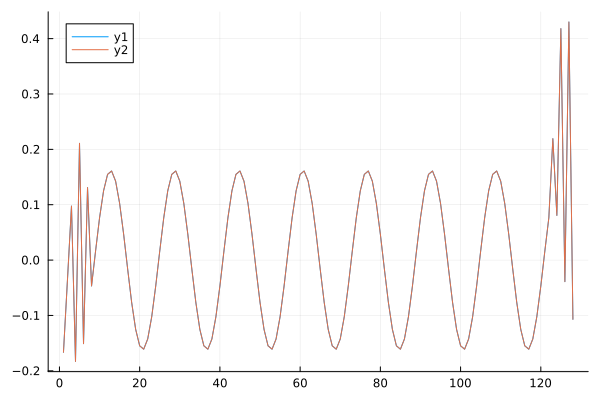

In [36]:
plot(real(tfrs[1, 1, 1, 14, :]))
plot!(real(py_tfrs_epoch0_channel0[1, 1, 14, :]))

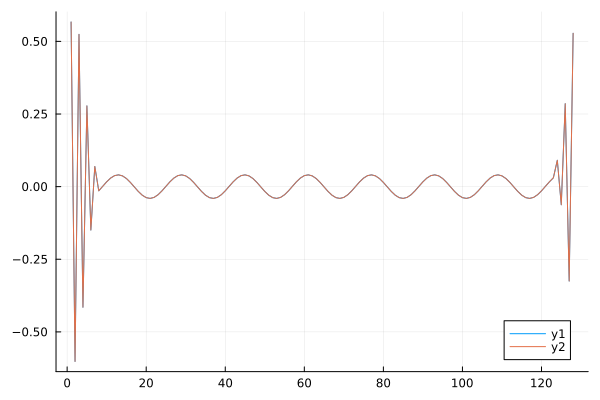

In [37]:
plot(imag(tfrs[1, 1, 1, 14, :]))
plot!(imag(py_tfrs_epoch0_channel0[1, 1, 14, :]))

# rest of calculation

In [38]:
size(psd_per_epoch)

LoadError: UndefVarError: `psd_per_epoch` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [39]:

epoch_idx = 1
expanded_weights = reshape(weights, (1, size(weights, 1), size(weights, 2), size(weights, 3)));

psd_per_epoch = zeros(size(data,1), size(data, 2), size(weights, 2), size(data, 3));
for epoch_idx = 1:size(data,1)
    # Perform the element-wise multiplication with broadcasting
    psd = expanded_weights .* tfrs[epoch_idx, :, :, :, :]
    
    # Square magnitude (complex conjugate multiplication)
    psd = psd .* conj(psd)
    
    # Sum across the second dimension (axis=1 in Python)
    psd = sum(real(psd), dims=2)
    
    # Calculate normalization factor for `weights`, matching dimensions
    normalization = 2 ./ sum(real(expanded_weights .* conj(expanded_weights)), dims=2)
    psd = psd .* normalization
    # @show size(psd)
    # psd_squeezed = dropdims(psd, dims=2);
    
    psd_per_epoch[epoch_idx, :, :, :] .= psd[:, 1, :, :]
end

In [40]:
size(psd_per_epoch)

(2, 4, 14, 128)

In [41]:
coherence = zeros(size(data, 1), size(data, 2), size(data, 2), size(psd_per_epoch, 3))

for epoch_idx = 1:size(data, 1)
    for x = 1:size(data, 2)
        for y = (x + 1):size(data, 2)  # Skip diagonal and only calculate for lower triangle
            w_x = tfrs[epoch_idx, x, :, :, :]
            w_y = tfrs[epoch_idx, y, :, :, :]
            s_xy = sum(weights .* w_x .* conj(weights .* w_y), dims=1)  # sum over tapers
            normalization = 2 ./ sum(real(weights .* conj(weights)), dims=1)
            s_xy = s_xy .* normalization

            s_xx = psd_per_epoch[epoch_idx, x, :, :]
            s_yy = psd_per_epoch[epoch_idx, y, :, :]

            coh_value = coh(s_xx, s_yy, s_xy[1, :, :])
            # coherence[epoch_idx, x, y, :] .= coh_value # Copy to symmetric position
            coherence[epoch_idx, y, x, :] .= coh_value  
        end
    end
end
coherence_mean = mean(coherence, dims=ndims(coherence));

In [42]:
# load array shaped (epoch,channel,channel,band) (1 in this case) for average
py_coh_org = npzread(joinpath(output_org_path, "coh_favg_unmodified_python.npy"));


In [43]:
@assert isapprox(coherence_mean, py_coh_org, atol=1e-14)

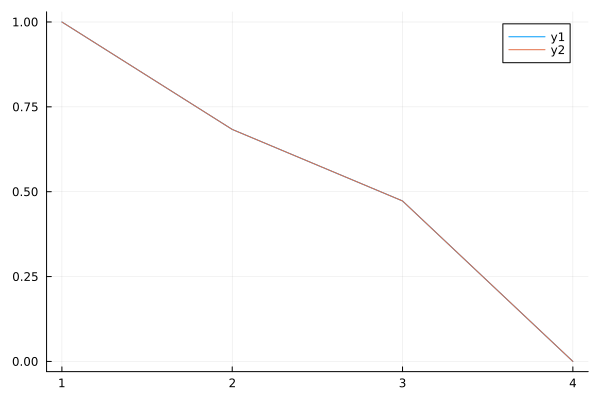

In [44]:
i=4
plot(coherence_mean[1, i, :, 1])
plot!(py_coh_org[1, i, :, 1])

# optimizations

In [ ]:
using LinearAlgebra, FFTW

function new_py_dpss(M::Int, NW::Float64, normalization_type::Int, Kmax::Int; sym::Bool=true)::Tuple{Array{Float64, 2}, Union{Array{Float64, 1}, Float64}}
    # Validate inputs
    known_norms = (1, 2, 3)
    if normalization_type ∉ known_norms
        error("normalization_type must be one of $known_norms, got $normalization_type")
    end
    if Kmax === 1
        singleton = true
    else
        singleton = false
    end
    if !(0 < Kmax <= M)
        error("Kmax must be greater than 0 and less than or equal to M")
    end
    if NW >= M / 2.0
        error("NW must be less than M/2.")
    end
    if NW <= 0
        error("NW must be positive")
    end

    M, needs_trunc = new_extend(M, sym)
    W = NW / M
    nidx = 0:M-1
    # Use SymTridiagonal for efficient eigenvalue computation
    d = ((M - 1 .- 2 .* nidx) ./ 2.0) .^ 2 .* cos(2pi * W)
    e = nidx[1:end-1] .* (M .- nidx[1:end-1]) ./ 2.0
    T = SymTridiagonal(d, e)
    eigs = eigen(T)
    # Extract the largest Kmax eigenvalues and eigenvectors
    indices = M-Kmax+1:M
    eigvals = eigs.values[indices]
    eigvecs = eigs.vectors[:, indices]
    # Transpose eigenvectors to get windows
    windows = eigvecs'
    # Correct sign conventions
    fix_even = sum(windows[1:2:end, :], dims=2) .< 0
    windows[1:2:end, :][fix_even[:,1], :] .*= -1

    # # Correct signs for even-indexed windows
    thresh = max(1e-7, 1.0 / M)
    for (i, w) in enumerate(eachrow(windows[2:2:end, :]))
        idx = findfirst(x -> x^2 > thresh, w)
        if idx !== nothing && w[idx] < 0
            windows[2i, :] *= -1
        end
    end

    # Compute concentration ratios
    dpss_rxx = new_fftautocorr(windows)
    r = 4 * W * sinc.(2 * W .* (0:M-1))
    r[1] = 2 * W
    ratios = dpss_rxx * r
    if singleton
        ratios = ratios[1]
    end
    # Apply normalization if needed
    if normalization_type != 1
        max_abs = maximum(abs, windows)
        windows ./= max_abs
        if iseven(M)
            if normalization_type == 2
                correction = M^2 / (M^2 + NW)
            elseif normalization_type == 3
                s = rfft(windows[1, :])
                shift = -(1 - 1.0 / M) .* (1:Int(M / 2))
                s[2:end] .*= 2 .* exp.(-im * π .* shift)
                correction = M / sum(real(s))
            end
            windows .*= correction
        end
    end
    if needs_trunc
        windows = windows[:, 1:end-1]
    end
    if singleton
        windows = windows[1, :]
    end
    return windows, ratios
end

function new_extend(M::Int, sym::Bool)::Tuple{Int, Bool}
    # Extend window by 1 sample if needed for DFT-even symmetry
    if !sym
        return M + 1, true
    else
        return M, false
    end
end



new_fftautocorr (generic function with 1 method)

In [48]:
dpss_out, eigenvals = py_dpss(112, 2.0, Kmax=3, sym=false, norm=2, return_ratios=true)

([0.0028541441929392118 0.003701534767082601 … 0.004660622404680171 0.003701534767082555; 0.01678315004877316 0.02006287546463611 … -0.02357156269110827 -0.020062875464635695; 0.06055502042222134 0.06700625407483701 … 0.07344843925213088 0.06700625407483614], [0.9999430567969021, 0.9975694042111699, 0.9594491709879721])

In [ ]:
dpss_out_new, eigenvals_new = new_py_dpss(112, 2.0, 2, 3)

LoadError: AssertionError: sz[d1] == d >> 1 + 1

In [151]:
M = 112
NW = 2.0
Kmax = 3
sym = false
return_ratios = true
normalization_type = 1
singleton = false;


M, needs_trunc = new_extend(M, sym)
W = NW / M
nidx = 0:M-1
# Use SymTridiagonal for efficient eigenvalue computation
d = ((M - 1 .- 2 .* nidx) ./ 2.0) .^ 2 .* cos(2pi * W)
e = nidx[1:end-1] .* (M .- nidx[1:end-1]) ./ 2.0
T = SymTridiagonal(d, e)
eigs = eigen(T)
# Extract the largest Kmax eigenvalues and eigenvectors
indices = M-Kmax+1:M
eigvals = eigs.values[indices]
eigvecs = eigs.vectors[:, indices]
# Transpose eigenvectors to get windows
windows = eigvecs'
# Correct sign conventions
fix_even = sum(windows[1:2:end, :], dims=2) .< 0
windows[1:2:end, :][fix_even[:,1], :] .*= -1

# # Correct signs for even-indexed windows
thresh = max(1e-7, 1.0 / M)
for (i, w) in enumerate(eachrow(windows[2:2:end, :]))
    idx = findfirst(x -> x^2 > thresh, w)
    if idx !== nothing && w[idx] < 0
        windows[2i, :] *= -1
    end
end

x = copy(windows)
a = _fftautocorr(x)
b = new_fftautocorr(x)
a == b


true

In [88]:
using BenchmarkTools

In [152]:
let x = copy(windows)
    @benchmark _fftautocorr(x)
end

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  125.735 μs … 199.073 ms  ┊ GC (min … max): 0.00% … 7.63%
 Time  (median):     143.034 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   178.623 μs ±   2.136 ms  ┊ GC (mean ± σ):  1.73% ± 0.22%

     ▃▆▅▂▁▂▂▄▆██▇▆▄▃▂▁ ▁▁ ▂▂▁▁                                   
  ▂▃▆██████████████████████████▇▆▅▄▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂ ▅
  126 μs           Histogram: frequency by time          195 μs <

 Memory estimate: 33.33 KiB, allocs estimate: 55.

In [153]:
let x = copy(windows)
    @benchmark new_fftautocorr(x)
end

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  69.797 μs … 127.021 ms  ┊ GC (min … max): 0.00% … 12.45%
 Time  (median):     77.337 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   90.395 μs ±   1.269 ms  ┊ GC (mean ± σ):  1.75% ±  0.12%

         ▂▄▇██▆▅▄▂▁       ▁▁▂▃▃▃▂▄▂▂▁                           
  ▁▁▂▂▃▅████████████▇█▇▇▇█████████████▇▇▆▆▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁ ▄
  69.8 μs         Histogram: frequency by time         89.1 μs <

 Memory estimate: 26.41 KiB, allocs estimate: 27.

In [ ]:



# Compute concentration ratios
dpss_rxx = new_fftautocorr(windows)
r = 4 * W * sinc.(2 * W .* (0:M-1))
r[1] = 2 * W
ratios = dpss_rxx * r
if singleton
    ratios = ratios[1]
end
# Apply normalization if needed
if normalization_type != 1
    max_abs = maximum(abs, windows)
    windows ./= max_abs
    if iseven(M)
        if normalization_type == 2
            correction = M^2 / (M^2 + NW)
        elseif normalization_type == 3
            s = rfft(windows[1, :])
            shift = -(1 - 1.0 / M) .* (1:Int(M / 2))
            s[2:end] .*= 2 .* exp.(-im * π .* shift)
            correction = M / sum(real(s))
        end
        windows .*= correction
    end
end
if needs_trunc
    windows = windows[:, 1:end-1]
end
if singleton
    windows = windows[1, :]
end
return windows, ratios